In [19]:
from __future__ import print_function, division

from time import time
import torch
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import time as tm
import os
import copy


plt.ion()   # interactive mode

In [21]:
train_data_path = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'

In [22]:
train_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
       transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

In [23]:
train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)

In [24]:
val_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)

In [25]:
# Assuming train_dataset is your complete dataset
num_train_samples = len(train_dataset)

# Define the validation split ratio
val_split = 0.2

# Calculate the number of samples for validation
split = int(num_train_samples * val_split)

# Set a seed for reproducibility
torch.manual_seed(1)

# Shuffle and split the indices
indices = torch.randperm(num_train_samples)
train_indices = indices[split:]
val_indices = indices[:split]

# Create Subset instances for training and validation
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Display the lengths of the training and validation sets
len(train_subset), len(val_subset)

(69600, 17400)

In [26]:
batch_size = 64
num_workers = 2

train_dataloader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size,shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_subset,batch_size=batch_size,shuffle=False)

In [27]:
classes = train_dataloader.dataset.dataset.classes

In [29]:
model_resnet = models.resnet50(pretrained=True)

In [30]:
for param in model_resnet.parameters():
    param.requires_grad = False

In [31]:
# Replace the last fully connected layer for the new classification task
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = torch.nn.Linear(num_ftrs, len(classes))  # Assuming 29 output classes for ASL Alphabet

params_to_update = []
for name, param in model_resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Send the model to device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Define the loss criterion for classification
criterion = torch.nn.CrossEntropyLoss()

# Choose an optimizer (e.g., Adam)
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.001)

In [32]:
from time import time
from tqdm import tqdm

def train(model, criterion, optimizer, train_dataloader, test_dataloader, num_epoch, device):
    steps = 0
    train_losses, val_losses = [], []

    model_resnet.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()

        model_resnet.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model_resnet(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer_ft.zero_grad()
            loss.backward()
            optimizer_ft.step()

            running_loss += loss.item()

        # Logging at the end of each epoch
        print(f'Epoch [{epoch + 1}/{num_epoch}].', end=' ')
        print(f'Train loss {running_loss / steps:.3f}.', end=' ')
        with torch.no_grad():
            model_resnet.eval()
            correct_val, total_val = 0, 0
            val_loss = 0
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                output = model_resnet(images)
                loss = criterion(output, labels)
                val_loss += loss.item()

                correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                total_val += labels.size(0)

            print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
            print(f'Took {time() - iter_time:.3f} seconds')

            train_losses.append(running_loss / total_train)
            val_losses.append(val_loss / total_val)

        print(f'Epoch took {time() - start_time}')
        torch.save(model_resnet, f'checkpoint_{correct_val / total_val * 100:.2f}')

    return model_resnet, train_losses, val_losses

In [33]:
num_epoch = 2

model_resnet, train_losses, val_losses = train(
    model=model_resnet,
    criterion=criterion,
    optimizer=optimizer_ft,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    device = device,
    num_epoch=num_epoch
)

Epoch [1/2]. Train loss 0.793. Val loss 0.362. Val acc 90.897. Took 567.829 seconds
Epoch took 567.828604221344
Epoch [2/2]. Train loss 0.156. Val loss 0.257. Val acc 92.678. Took 589.109 seconds
Epoch took 589.1095175743103


In [60]:
from pathlib import Path
from PIL import Image


test_data_path = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()

        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')

        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)

        return img, label

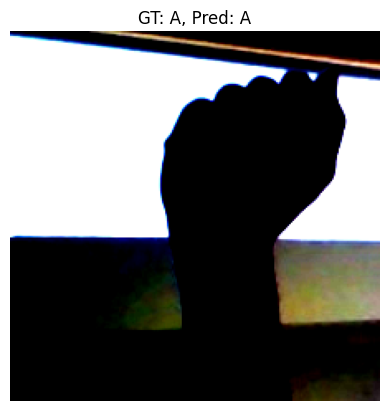

Image 1 - GT: A, Pred: A


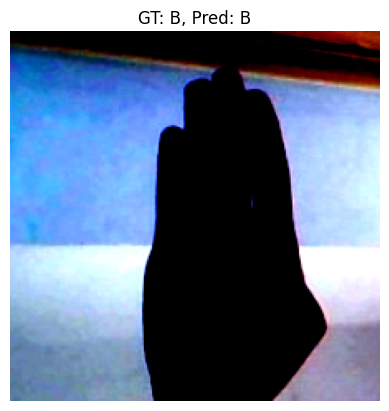

Image 1 - GT: B, Pred: B


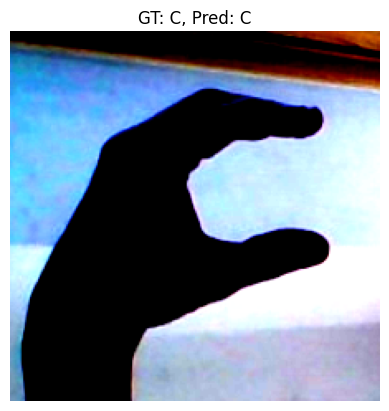

Image 1 - GT: C, Pred: C


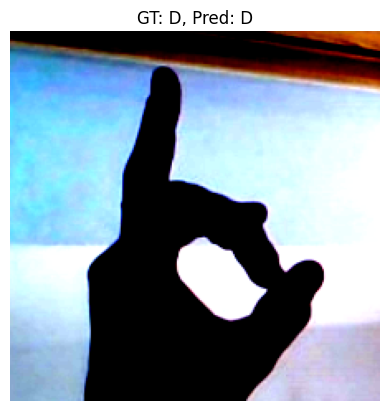

Image 1 - GT: D, Pred: D


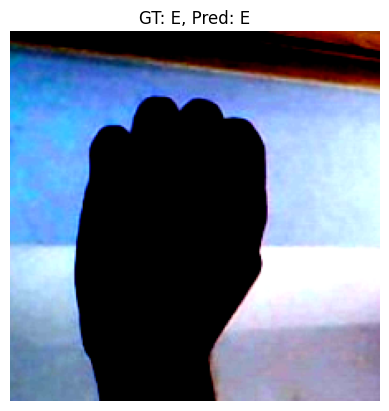

Image 1 - GT: E, Pred: E


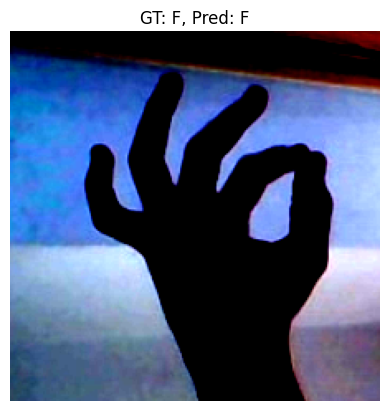

Image 1 - GT: F, Pred: F


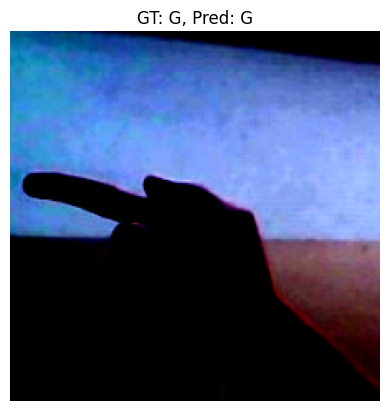

Image 1 - GT: G, Pred: G


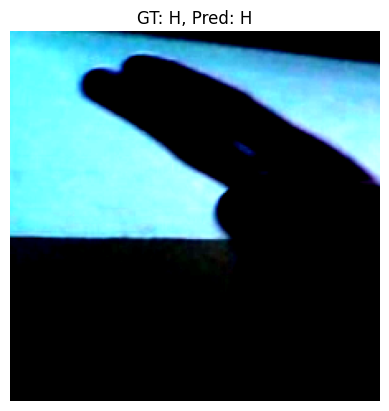

Image 1 - GT: H, Pred: H


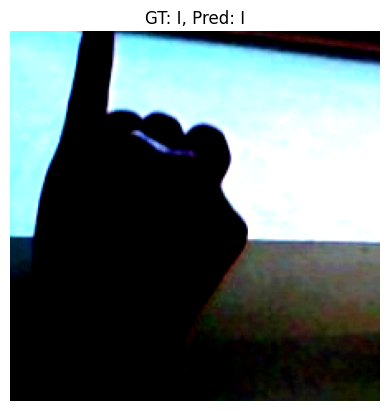

Image 1 - GT: I, Pred: I


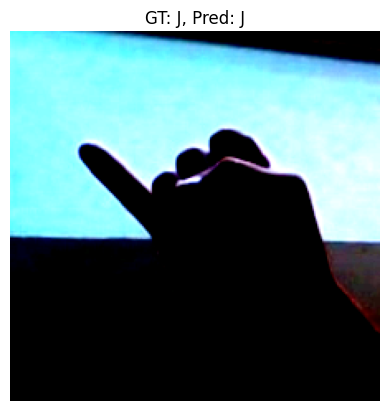

Image 1 - GT: J, Pred: J


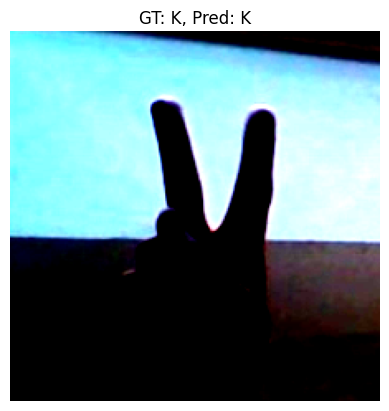

Image 1 - GT: K, Pred: K


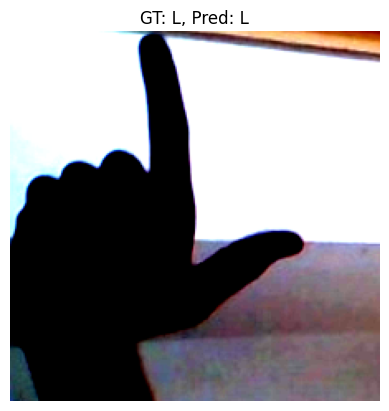

Image 1 - GT: L, Pred: L


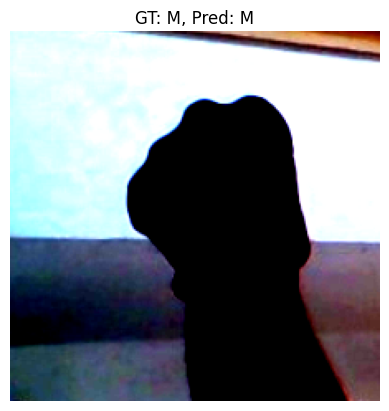

Image 1 - GT: M, Pred: M


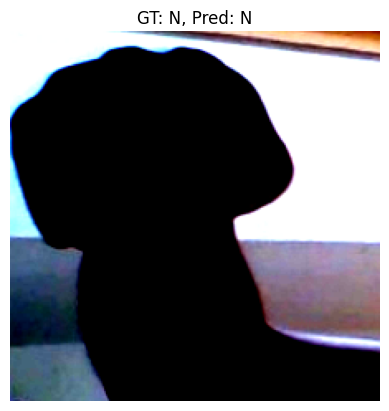

Image 1 - GT: N, Pred: N


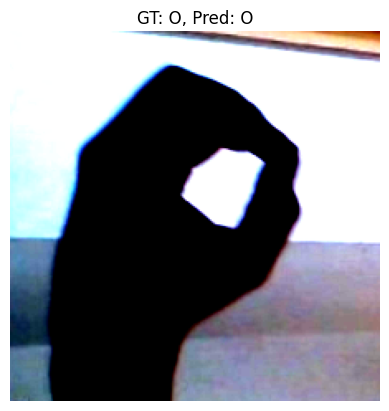

Image 1 - GT: O, Pred: O


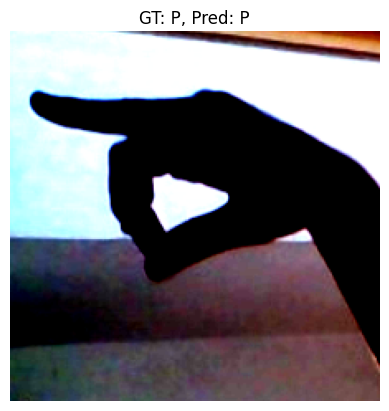

Image 1 - GT: P, Pred: P


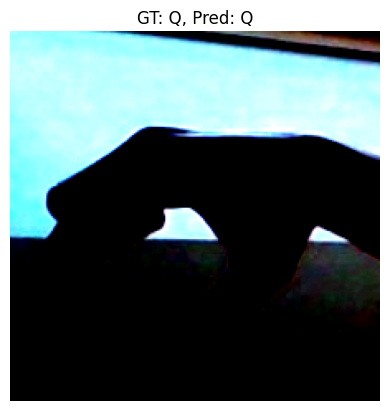

Image 1 - GT: Q, Pred: Q


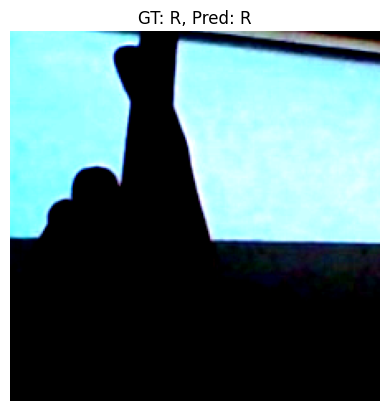

Image 1 - GT: R, Pred: R


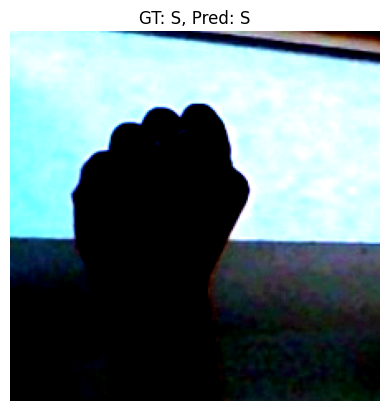

Image 1 - GT: S, Pred: S


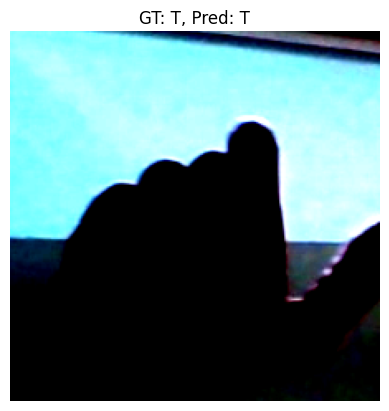

Image 1 - GT: T, Pred: T


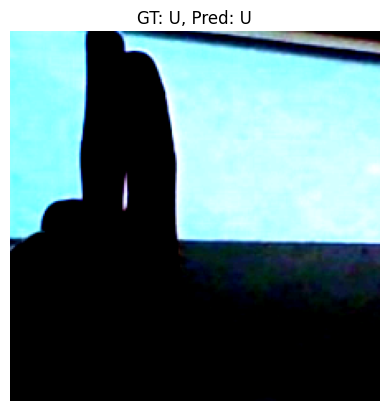

Image 1 - GT: U, Pred: U


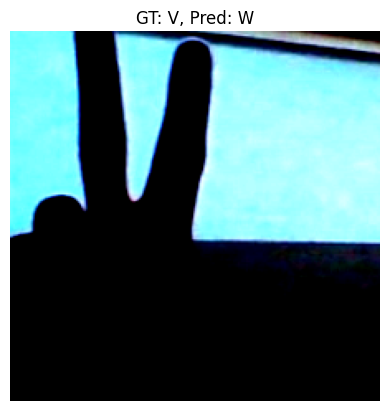

Image 1 - GT: V, Pred: W


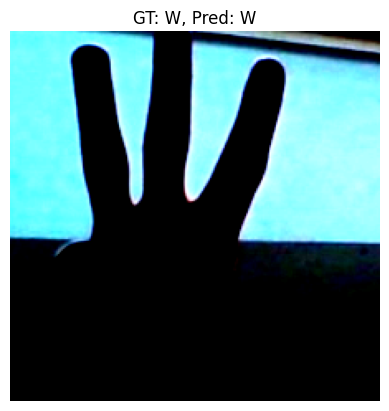

Image 1 - GT: W, Pred: W


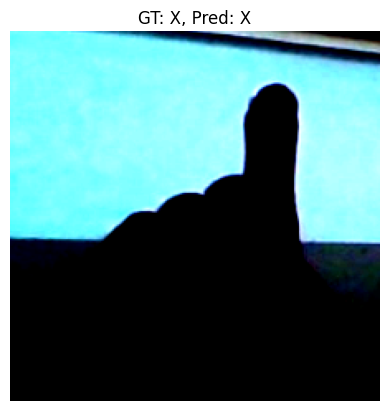

Image 1 - GT: X, Pred: X


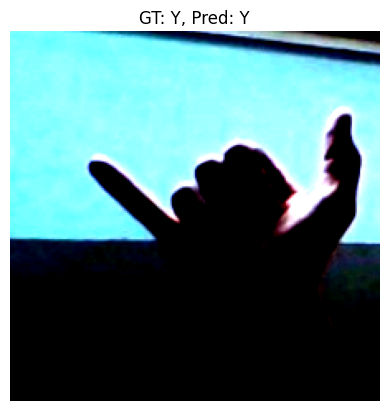

Image 1 - GT: Y, Pred: Y


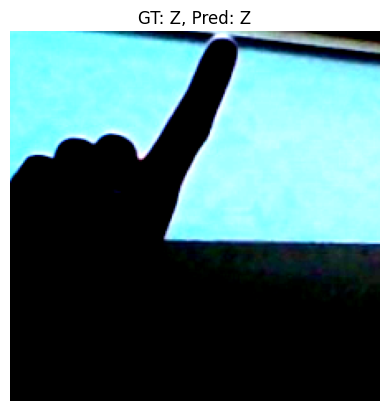

Image 1 - GT: Z, Pred: Z


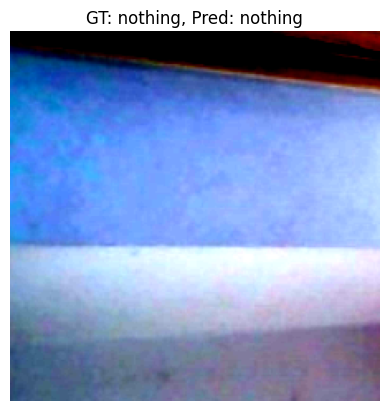

Image 1 - GT: nothing, Pred: nothing


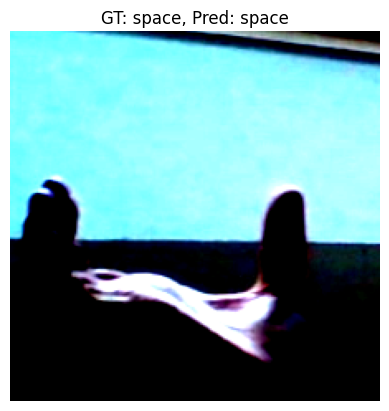

Image 1 - GT: space, Pred: space


In [65]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Assuming you have defined your ASLTestDataset class
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set batch_size to 1

# Set the model to evaluation mode
model_resnet.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Iterate over the test dataset
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model_resnet(inputs)

    # Get predictions
    _, predictions = torch.max(outputs, 1)

    # Append predictions and labels to the lists
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.append(labels[0])  # Unpack the tuple and get the label (assuming it's a string)

    # Display the images with their predicted labels
    for i in range(inputs.size(0)):
        image = inputs[i].cpu().permute(1, 2, 0)
        label = all_labels[-1]  # Use the last appended label
        prediction = classes[all_predictions[-1]]  # Use the last appended prediction

        plt.imshow(image)
        plt.title(f'GT: {label}, Pred: {prediction}')
        plt.axis('off')
        plt.show()

        print(f"Image {i + 1} - GT: {label}, Pred: {prediction}")

# Convert the predictions list to a numpy array
all_predictions = np.array(all_predictions)


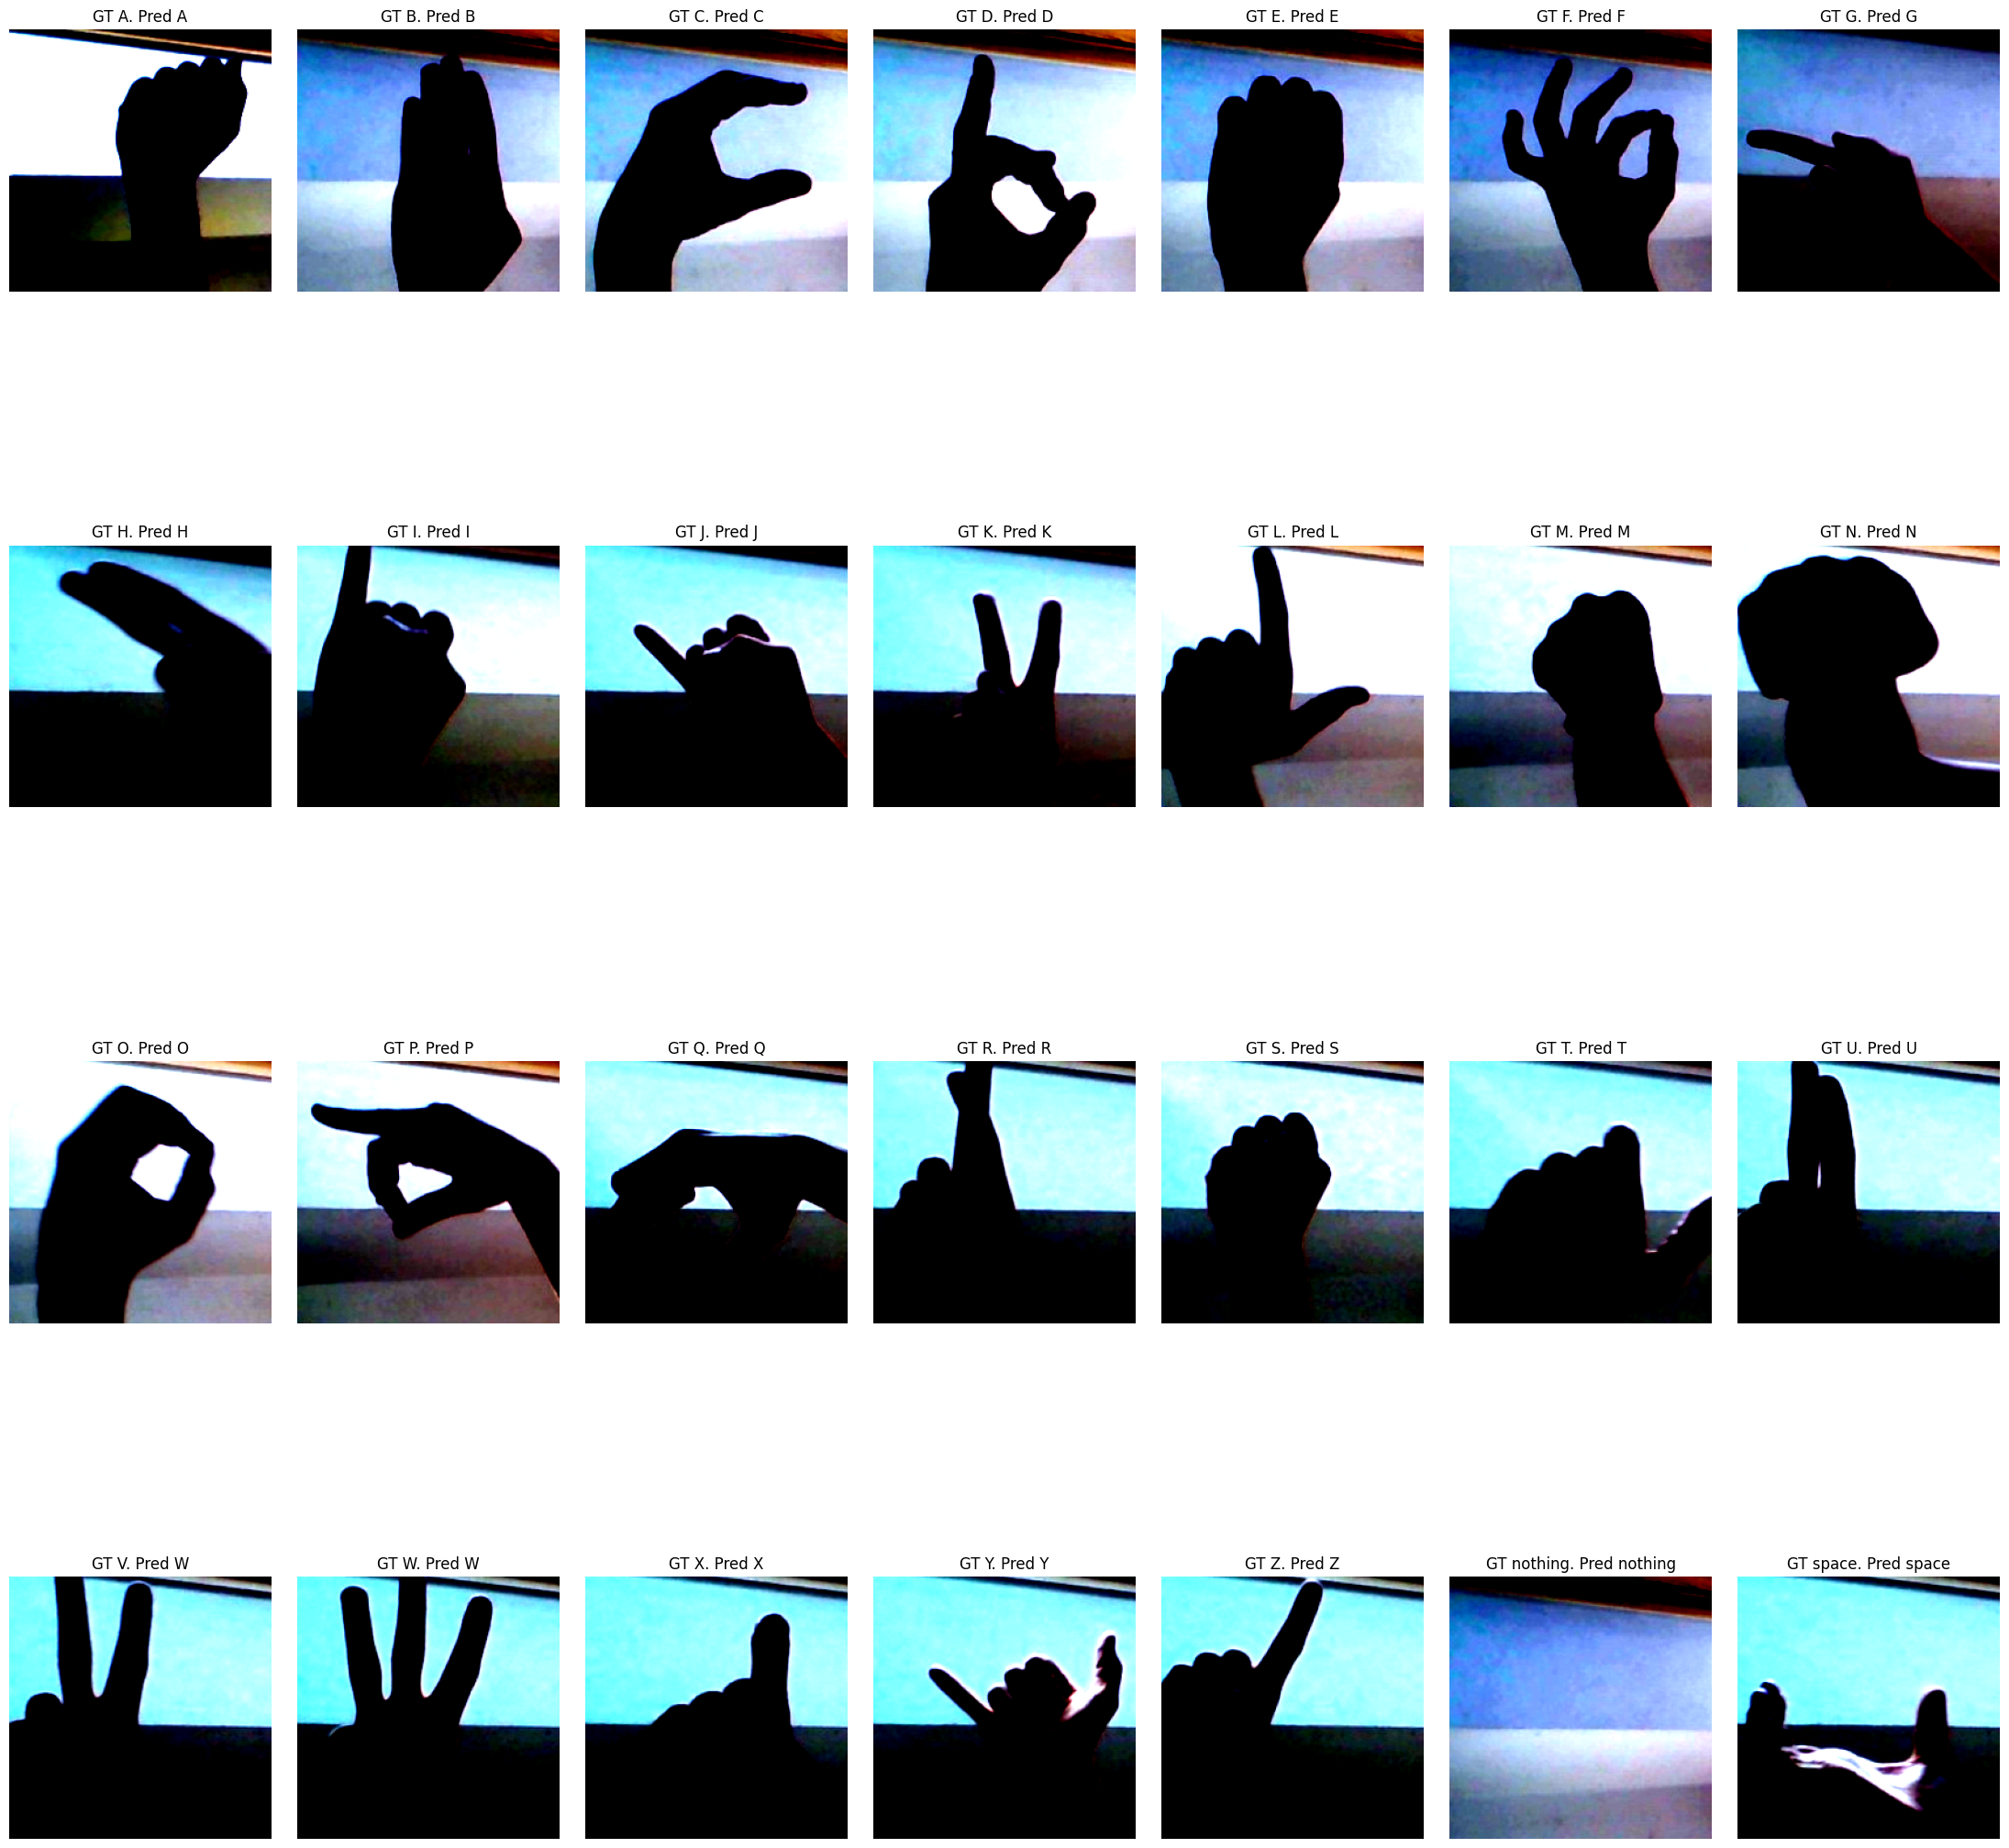

In [68]:
# Assuming you have defined your ASLTestDataset class
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)

columns = 7
row = max(1, round(len(test_dataset) / columns))

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)



i, j = 0, 0
for img, label in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    model_resnet.eval()  # Assuming you have renamed the model to model_resnet
    prediction = model_resnet(img[None])

    ax[i][j].imshow(img.cpu().permute(1, 2, 0))
    ax[i][j].set_title(f'GT {label}. Pred {classes[torch.max(prediction, dim=1)[1]]}')
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1

plt.show()